In [3]:
using Seismic, PyPlot

# Test the Parabolic Radon Transform with a synthetic example 
# The Radon coefficients are computed via LS inversion using fx domain data



In [59]:
# 1-  Make an ideal Radon Gather (Radon coefficients in tau-p) 

source = Ricker()
ns = length(source)
np = 100
nt = 600
nw = nt
nh = 80
dt = 0.004
h = collect(linspace(0.0, 1000.0, nh))      # Desired offset of CMP gather 
p = collect(linspace(-0.04, 2.2, np))       # Residual moveout at far offset 
m = zeros(Float64, nt, np)
for is = 1:ns
    m[160+is,  3] =  source[is]
    m[ 60+is, 44] = -source[is]
    m[280+is, 44] =  source[is]
    m[240+is,  3] = -source[is]
end
href = maximum(abs.(h))

# 2- Model the data using the forward Radon transform and add noise to it

param = Dict(:order=>"parab", :dt=>dt, :p=>p, :h=>h, :href=>href, :flow=>0.0, :fhigh=>125.0)

d = SeisRadonFreqFor(m, nt; param...)

# *** you can play with SNR and mu to explore the resolution-noise tradeoff *** 

snr = 2.5
 mu = 0.01     # Trade-off parameter (Damping) for SeisRadonFreqInv (inverse Radon transform)

d = SeisAddNoise(d,snr; L=3)

# 3- Recover Radon gather via LS inversion

m = SeisRadonFreqInv(d; param..., mu=mu)

# 4- Filter primaries and keep multiples in Radon gather  

  mf = copy(m);
pcut = 0.3
icut = find(p .< pcut)
mf[:, icut] = 0.0

# 5- Recover multiples by forward modelling

d_mult = SeisRadonFreqFor(mf, nt; param...)
 
# 6- Substract multiples from data to obtain primaries

d_prim = d - d_mult 
dp = p[2] - p[1]
dh = h[2] - h[1];



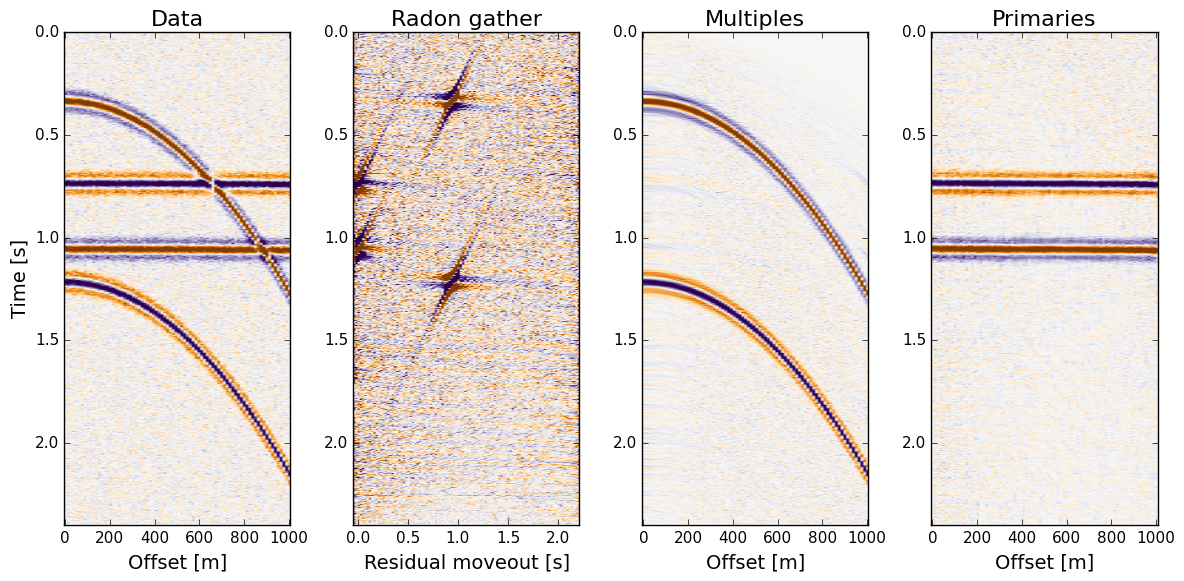

In [60]:
# 7- Plotting  

figure(1, figsize=(12,6));
subplot(141)
SeisPlot(d, title="Data", xlabel="Offset [m]", ylabel="Time [s]",
         vmin=-0.8, vmax = 0.8, ox=h[1], dx=dh, dy=dt, fignum=1)

subplot(142)
SeisPlot(m[1:nt, :], title="Radon gather", xlabel="Residual moveout [s]",
         ox=p[1], dx=dp, dy=dt, fignum=1)

subplot(143)
SeisPlot(d_mult, title="Multiples", xlabel="Offset [m]",
         vmin=-0.8, vmax = 0.8, ox=h[1], dx=dh, dy=dt, fignum=1)

subplot(144)
SeisPlot(d_prim, title="Primaries", xlabel="Offset [m]",
         vmin=-0.8, vmax = 0.8, ox=h[1], dx=dh, dy=dt, fignum=1)

tight_layout()



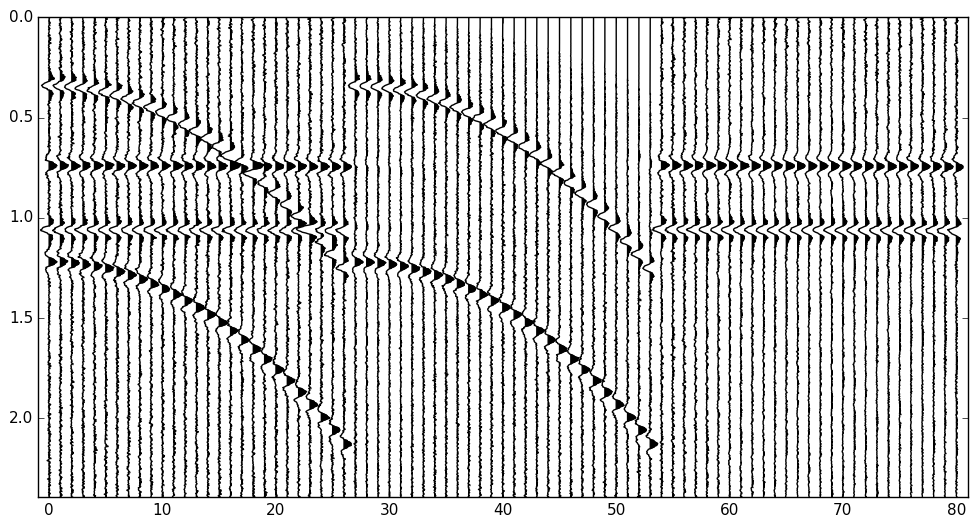

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1349fd910>

In [63]:
# 8- Compare amplitudes for QC   

figure(2, figsize=(12,6));

# Plot data, estimated multiples and estimated primaries every 3rd trace

SeisPlot(hcat(d[:,1:3:end],d_mult[:,1:3:end],d_prim[:,1:3:end]),style="wiggles", dy=dt, fignum=2)